In [16]:
# Import the required libraries.
import re
import math
import random
import collections
import operator
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict, Counter
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

random.seed(11)
np.random.seed(11)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, InputLayer, Bidirectional, TimeDistributed, Embedding, Activation, Masking
from keras.optimizers import Adam, SGD
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [3]:
from google.colab import files
uploaded = files.upload()

Saving Brown_train.txt to Brown_train.txt


In [0]:
def parse_sentence(sentence):
    '''
    Function for parsing the words and tags from the
    sentences of the input corpus.
    '''
    word_tag_pairs = sentence.split(" ")
    words = []
    tags = []

    for i, word_tag in enumerate(word_tag_pairs):
        word, tag = word_tag.strip().rsplit('/', 1)
        words.append(word)
        tags.append(tag)
        
    return words, tags

In [0]:
# Parse the sentences into a list.
parsed_sentences = []

with open('./Brown_train.txt', 'r') as file:
    sentences = file.readlines()

    for sentence in sentences:
        sentence = sentence.strip()
        parsed_sentences.append(parse_sentence(sentence))

In [0]:
def get_vocab(X_train, Y_train):
    '''
    Function for building the vocabulary from the training set of
    words and tags.
    '''
    vocabulary2id = dict()    
    tag2id = dict()
    vocabulary2id['PAD'] = 0
    vocabulary2id['UNK'] = 1

    for sent in X_train:
        for word in sent:
            if word not in vocabulary2id.keys():
                vocabulary2id[word] = len(vocabulary2id)
    
    tag2id['PAD'] = 0
    for sent in Y_train:
        for tag in sent:
            if tag not in tag2id.keys():
                tag2id[tag] = len(tag2id)
    
    return vocabulary2id, tag2id

def get_word_tag_counts(X_train, Y_train, vocabulary2id, tag2id):
    '''
    Function for calculating the counts pertaining to the
    individual word tags.
    '''
    wordcount = defaultdict(int)
    tagcount = defaultdict(int)
    tagpaircount = defaultdict(int)
    tagtriplecount = defaultdict(int)
    
    for sent in X_train:
        for word in sent:
            wordcount[word] += 1
    
    for sent in Y_train:
        for tag in sent:
            tagcount[tag] += 1
    
    for sent in Y_train:
        for i in range(len(sent) - 1):
            tagpaircount[sent[i], sent[i + 1]] += 1

    for sent in Y_train:
        for i in range(len(sent) - 2):
            tagtriplecount[sent[i], sent[i + 1], sent[i + 2]] += 1
    
    return wordcount, tagcount, tagpaircount, tagtriplecount

In [7]:
parsed_sentences[:5]

[(['At',
   'that',
   'time',
   'highway',
   'engineers',
   'traveled',
   'rough',
   'and',
   'dirty',
   'roads',
   'to',
   'accomplish',
   'their',
   'duties',
   '.'],
  ['ADP',
   'DET',
   'NOUN',
   'NOUN',
   'NOUN',
   'VERB',
   'ADJ',
   'CONJ',
   'ADJ',
   'NOUN',
   'PRT',
   'VERB',
   'DET',
   'NOUN',
   '.']),
 (['Using',
   'privately-owned',
   'vehicles',
   'was',
   'a',
   'personal',
   'hardship',
   'for',
   'such',
   'employees',
   ',',
   'and',
   'the',
   'matter',
   'of',
   'providing',
   'state',
   'transportation',
   'was',
   'felt',
   'perfectly',
   'justifiable',
   '.'],
  ['VERB',
   'ADJ',
   'NOUN',
   'VERB',
   'DET',
   'ADJ',
   'NOUN',
   'ADP',
   'ADJ',
   'NOUN',
   '.',
   'CONJ',
   'DET',
   'NOUN',
   'ADP',
   'VERB',
   'NOUN',
   'NOUN',
   'VERB',
   'VERB',
   'ADV',
   'ADJ',
   '.']),
 (['Once',
   'the',
   'principle',
   'was',
   'established',
   ',',
   'the',
   'increase',
   'in',
   'state-owned'

In [0]:
def build_model():
    model = Sequential()
    # model.add(InputLayer(input_shape=(padlen, )))
    model.add(Masking(mask_value=float(vocabulary2id['UNK']),input_shape=(padlen,)))
    model.add(Embedding(len(vocabulary2id), 100))
    model.add(Bidirectional(LSTM(int((128+256)/2), return_sequences=True)))
    model.add(TimeDistributed(Dense(len(tag2id))))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(0.001),
                  metrics=['accuracy'])
    model.summary()
    return model

In [0]:
def id2onehot(Y, numtags):
    out = []
    for s in Y:
        categories = []
        for item in s:
            categories.append(np.zeros(numtags))
            categories[-1][item] = 1.0
        out.append(categories)
    return np.array(out)

In [10]:
# Build the test and training sets of sentences.
kf = KFold(n_splits = 3, shuffle = False)
parsed_sentences = np.asarray(parsed_sentences)
scores = []
scores1 = []
y_pred_idx = []
y_pred_idx1 = []
y_test_idx = []
y_test_idx1 = []

preds_all_folds = []
golds_all_folds = []

for fold_num, (train_index, test_index) in enumerate(kf.split(parsed_sentences)):
    train_data = parsed_sentences[train_index]
    test_data = parsed_sentences[test_index]
    X_train = [a[0] for a in train_data]
    Y_train = [a[1] for a in train_data]
    X_test = [a[0] for a in test_data]
    Y_test = [a[1] for a in test_data]
    
    # Build the vocabulary and word counts.
    vocabulary2id, tag2id = get_vocab(X_train, Y_train)
    
    padlen = max(len(i) for i in X_train)
    def pad(sentence, padid=vocabulary2id['PAD']):
        out = sentence[:padlen]
        padding = [padid for _ in range(padlen - len(out))]
        return out + padding
    
    X_train_ids = np.asarray([pad([vocabulary2id[word] if word in vocabulary2id.keys() else vocabulary2id['UNK'] for word in sent]) for sent in X_train])
    X_test_ids = np.array([pad([vocabulary2id[word] if word in vocabulary2id.keys() else vocabulary2id['UNK'] for word in sent]) for sent in X_test])

    Y_train_ids = np.asarray([pad([tag2id[word] if word in tag2id.keys() else tag2id['UNK'] for word in sent], tag2id['PAD']) for sent in Y_train])
    Y_test_ids = np.asarray([pad([tag2id[word] if word in tag2id.keys() else tag2id['UNK'] for word in sent], tag2id['PAD']) for sent in Y_test])

    Y_train_onehot = id2onehot(Y_train_ids, len(tag2id))
    Y_test_onehot = id2onehot(Y_test_ids, len(tag2id))

    model = build_model()
    model.fit(X_train_ids, Y_train_onehot, batch_size=128, epochs=5, validation_split=0.2)

    predictions = model.predict(X_test_ids)

    # test_accuracy = np.sum((Y_test_ids == np.argmax(predictions, axis=-1)) * (Y_test_ids != 0)) / np.sum((Y_test_ids != 0))
    # print('Fold {} test_accuracy: {}'.format(fold_num + 1, test_accuracy))

    predictions_argmax = np.argmax(predictions, axis=-1)

    y_pred_nopad = []
    y_true_nopad = []

    for i in range(len(Y_test_ids)):
        for j in range(len(Y_test_ids[i])):
            if Y_test_ids[i][j] != 0 and predictions_argmax[i][j] != 0:
                y_true_nopad.append(Y_test_ids[i][j])
                if predictions_argmax[i][j] == 0:
                    y_pred_nopad.append(1)
                else:
                    y_pred_nopad.append(predictions_argmax[i][j])

    preds_all_folds.append(y_pred_nopad)
    golds_all_folds.append(y_true_nopad)

    y_pred_nopad = np.asarray(y_pred_nopad)
    y_true_nopad = np.asarray(y_true_nopad)
    test_accuracy = (y_pred_nopad == y_true_nopad).mean()
    print('Fold {} test_accuracy: {}'.format(fold_num + 1, test_accuracy))
    prec, rec, fscore, _ = precision_recall_fscore_support(y_true_nopad, y_pred_nopad, average = 'weighted')
    print('Fold {} Precision: {} Recall: {} F1-Score: {}'.format(fold_num + 1, prec, rec, fscore))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, 172)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 172, 100)          2211500   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 172, 384)          450048    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 172, 13)           5005      
_________________________________________________________________
activation_1 (Activation)    (None, 172, 13)           0         
Total params: 2,666,553
Trainable params: 2,666,553
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 14661 samples, validate on 3666 samples
Epoch 1/5
14661/14661 [==============================] - 66s 5ms/step - loss: 0.3480 - accuracy: 0.9078 - val_loss: 0.2182 - val_accuracy: 0.9200
Epoch 2/5
14661/14661 [==============================] - 64s 4ms/step - loss: 0.1871 - accuracy: 0.9374 - val_loss: 0.1649 - val_accuracy: 0.9544
Epoch 3/5
14661/14661 [==============================] - 64s 4ms/step - loss: 0.1083 - accuracy: 0.9697 - val_loss: 0.0757 - val_accuracy: 0.9770
Epoch 4/5
14661/14661 [==============================] - 64s 4ms/step - loss: 0.0417 - accuracy: 0.9898 - val_loss: 0.0307 - val_accuracy: 0.9927
Epoch 5/5
14661/14661 [==============================] - 64s 4ms/step - loss: 0.0162 - accuracy: 0.9963 - val_loss: 0.0204 - val_accuracy: 0.9943
Fold 1 test_accuracy: 0.9010598534402203
Fold 1 Precision: 0.9030468569039867 Recall: 0.9010598534402203 F1-Score: 0.8959284425488834
Model: "sequential_2"
_________________________________________________________________

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_3 (Masking)          (None, 386)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 386, 100)          2745900   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 386, 384)          450048    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 386, 13)           5005      
_________________________________________________________________
activation_3 (Activation)    (None, 386, 13)           0         
Total params: 3,200,953
Trainable params: 3,200,953
Non-trainable params: 0
_________________________________________________________________
Train on 14662 samples, validate on 3666 samples
Epoch 1/5
14662/14662 [==============================] - 143s

In [11]:
print("---Averaged Results over all the epochs---")
test_accuracy = (np.asarray(preds_all_folds[0]) == np.asarray(golds_all_folds[0])).mean()
print('Average K-Fold Test Accuracy: {}'.format(test_accuracy))
prec, rec, fscore, _ = precision_recall_fscore_support(preds_all_folds[0], golds_all_folds[0], average = 'weighted')
print('Average K-Fold Precision: {} Recall: {} F1-Score: {}'.format(prec, rec, fscore))

---Averaged Results over all the epochs---
Average K-Fold Test Accuracy: 0.9010598534402203
Average K-Fold Precision: 0.9175752724543983 Recall: 0.9010598534402203 F1-Score: 0.9061912643315573


In [12]:
id2tag = {v: k for k, v in tag2id.items()}
print(classification_report([id2tag[i] for i in golds_all_folds[0]], [id2tag[i] for i in preds_all_folds[0]]))

              precision    recall  f1-score   support

           .       0.98      0.99      0.99     29546
         ADJ       0.85      0.90      0.88     35928
         ADP       0.99      0.98      0.99      8037
         ADV       0.87      0.65      0.74     20489
        CONJ       0.84      0.93      0.88     63542
         DET       0.83      0.78      0.81     10637
        NOUN       1.00      1.00      1.00     26230
         NUM       0.98      0.97      0.98      4858
        PRON       0.96      0.26      0.42      4723
         PRT       0.97      0.95      0.96     35048
        VERB       0.77      0.91      0.83      4666
           X       0.00      0.00      0.00       292

    accuracy                           0.90    243996
   macro avg       0.84      0.78      0.79    243996
weighted avg       0.90      0.90      0.90    243996



In [0]:
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    #plt.savefig(filename)
    plt.show()

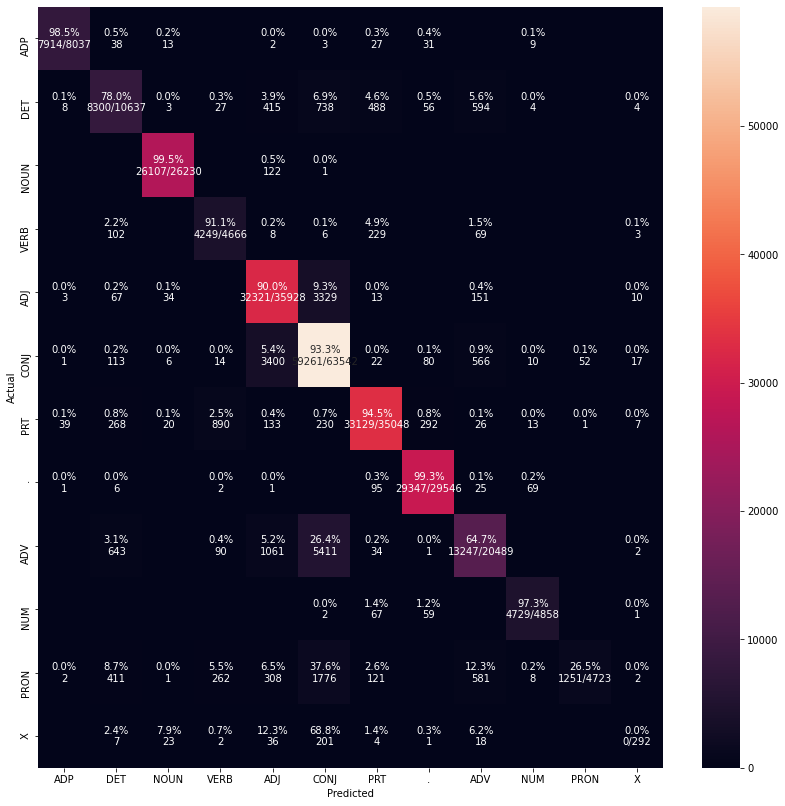

In [17]:
cm_analysis([id2tag[i] for i in golds_all_folds[0]], [id2tag[i] for i in preds_all_folds[0]], sorted(tag2id.keys(), key=lambda k: tag2id[k])[1:], ymap=None, figsize=(14, 14))

In [18]:
print("Tag-wise counts and accuracies\n--\n")
print("Tag\tGold Tag Count\tTotal predicted correctly\tTotal predicted incorrectly\tAccuracy")
gold_counts = Counter([id2tag[i] for i in golds_all_folds[0]])
pred_counts_correct = Counter([id2tag[t] for i, t in enumerate(preds_all_folds[0]) if t == golds_all_folds[0][i]])
pred_counts_incorrect = Counter([id2tag[t] for i, t in enumerate(preds_all_folds[0]) if t != golds_all_folds[0][i]])
for tag in gold_counts.keys():
  print(f"{tag}\t{gold_counts[tag]}\t\t{pred_counts_correct[tag]}\t\t\t\t{pred_counts_incorrect[tag]}\t\t\t\t{pred_counts_correct[tag] / gold_counts[tag]}")

Tag-wise counts and accuracies
--

Tag	Gold Tag Count	Total predicted correctly	Total predicted incorrectly	Accuracy
PRT	35048		33129				1100				0.9452465190595755
.	29546		29347				520				0.993264739727882
CONJ	63542		59261				11697				0.9326272386767807
ADJ	35928		32321				5486				0.8996047650857271
ADV	20489		13247				2030				0.646542046952023
ADP	8037		7914				54				0.9846957820082121
VERB	4666		4249				1287				0.910630090012859
NOUN	26230		26107				100				0.9953107129241326
DET	10637		8300				1655				0.7802951960139137
PRON	4723		1251				53				0.2648740207495236
NUM	4858		4729				113				0.9734458624948539
X	292		0				46				0.0
